In [1]:
import numpy as np
import numpy.ma as ma

from mpl_toolkits import mplot3d
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["text.usetex"] = False
from matplotlib import cm, colors
from matplotlib.patches import Ellipse
import matplotlib as mpl
from numpy import arange,array,ones,linalg
from scipy.optimize import minimize
from scipy import stats

from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs import WCS
from astropy.utils.data import get_pkg_data_filename
from astropy.visualization.wcsaxes import SphericalCircle
from astropy.nddata import bitmask
from astropy.nddata.bitmask import BitFlagNameMap
import math
import os 

import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

from scipy.ndimage import gaussian_filter1d

In [3]:
# Open SGA catalog
SGA_color_data = Table.read('SGA_Color_Params.fits')

FileNotFoundError: [Errno 2] No such file or directory: 'SGA_Color_Params.fits'

In [3]:
# Bits in the dict
MASKBITS = dict(
    NPRIMARY   = 0x1,   # not PRIMARY
    BRIGHT     = 0x2,
    SATUR_G    = 0x4,
    SATUR_R    = 0x8,
    SATUR_Z    = 0x10,
    ALLMASK_G  = 0x20,
    ALLMASK_R  = 0x40,
    ALLMASK_Z  = 0x80,
    WISEM1     = 0x100, # WISE masked
    WISEM2     = 0x200,
    BAILOUT    = 0x400, # bailed out of processing
    MEDIUM     = 0x800, # medium-bright star
    GALAXY     = 0x1000, # SGA large galaxy
    CLUSTER    = 0x2000, # Cluster catalog source
    SATUR_I    = 0x4000,
    ALLMASK_I  = 0x8000,
    SUB_BLOB   = 0x10000,
)

In [1]:
n_galaxies = len(SGA_color_data)

gini_g_band = np.NaN * np.ones(n_galaxies)
gini_r_band = np.NaN * np.ones(n_galaxies)
gini_z_band = np.NaN * np.ones(n_galaxies)
no_bitmask = []
no_image_path = []
image_shape_unknown = []

for i in range(0, n_galaxies): 
    f1 = math.trunc(SGA_color_data['RA'][i])
    f2 = math.trunc((1000*SGA_color_data['RA'][i]))
    f3 = math.trunc((100000*SGA_color_data['RA'][i]))
    f4 = 'm' if SGA_color_data['DEC'][i] < 0 else 'p'
    f5 = abs(math.trunc((100000*SGA_color_data['DEC'][i])))
    path = '/pscratch/sd/b/barnerg/SGA2024/cutouts/{:03d}/{:06d}/{:08d}{}{:07d}.fits'.format(f1,f2,f3,f4,f5)
    
    if os.path.exists(path):
        fits_file = fits.open(path, ignore_missing_simple=True, ignore_missing_end=True)
        
        try:
            fits_file[1].data
        except:
            no_bitmask.append(path)
            var_exists = False
        else:
            var_exists = True
            
        if var_exists: 
            image = fits_file[0].data
            bit_mask = fits_file[1].data
            fits_file.close()
            
            if image.shape[0] == 3:
                image = np.transpose(image, (1, 2, 0))

                condition = bit_mask & MASKBITS['GALAXY'] != 0
                mask_ = condition.astype(int)
                condition2 = mask_ & (MASKBITS['BRIGHT'] | MASKBITS['SATUR_G'] | MASKBITS['SATUR_R'] | MASKBITS['SATUR_Z'] | MASKBITS['WISEM1'] | MASKBITS['WISEM2']) != 0
                # mask_2 = np.where(mask_ == condition2, 1, 0)
                mask_2 = mask_ & ~condition2

                # mask each color separately 
                mg_image = ma.array(image[:,:,0], mask=~mask_2.astype(bool))
                mr_image = ma.array(image[:,:,1], mask=~mask_2.astype(bool))
                mz_image = ma.array(image[:,:,2], mask=~mask_2.astype(bool))
                g = mg_image.compressed()
                r = mr_image.compressed()
                z = mz_image.compressed()
                g_filter = g[g > 0]
                r_filter = r[r > 0]
                z_filter = z[z > 0]

                # gini coefficient g band
                n = len(g_filter)    
                sorted_x = np.sort(g_filter)    
                numerator = np.sum([((2*i - n - 1) * sorted_x[i-1]) for i in range(1, n+1)])
                denominator =  np.mean(sorted_x) * n * (n-1)
                gini_g = numerator / denominator
                gini_g_band[i] = gini_g 

                # gini coefficient r band
                n = len(r_filter)    
                sorted_x = np.sort(r_filter)    
                numerator = np.sum([((2*i - n - 1) * sorted_x[i-1]) for i in range(1, n+1)])
                denominator =  np.mean(sorted_x) * n * (n-1)
                gini_r = numerator / denominator  
                gini_r_band[i] = gini_r

                # gini coefficient z band
                n = len(z_filter)    
                sorted_x = np.sort(z_filter)    
                numerator = np.sum([((2*i - n - 1) * sorted_x[i-1]) for i in range(1, n+1)])
                denominator =  np.mean(sorted_x) * n * (n-1)
                gini_z = numerator / denominator 
                gini_z_band[i] = gini_z
            
            else:
                image_shape_unknown.append(path)
    else: 
        no_image_path.append(path)


NameError: name 'SGA_color_data' is not defined

In [1]:
len(no_bitmask), len(no_image_path)

NameError: name 'no_bitmask' is not defined

In [9]:
no_image_path

['/pscratch/sd/b/barnerg/SGA2024/cutouts/216/216421/21642142p3237294.fits',
 '/pscratch/sd/b/barnerg/SGA2024/cutouts/134/134424/13442474p3237946.fits',
 '/pscratch/sd/b/barnerg/SGA2024/cutouts/180/180417/18041772p3238438.fits',
 '/pscratch/sd/b/barnerg/SGA2024/cutouts/135/135688/13568855p3236544.fits',
 '/pscratch/sd/b/barnerg/SGA2024/cutouts/132/132773/13277302p3237535.fits',
 '/pscratch/sd/b/barnerg/SGA2024/cutouts/169/169265/16926569p3237335.fits',
 '/pscratch/sd/b/barnerg/SGA2024/cutouts/210/210242/21024253p3237806.fits',
 '/pscratch/sd/b/barnerg/SGA2024/cutouts/187/187094/18709450p3238199.fits',
 '/pscratch/sd/b/barnerg/SGA2024/cutouts/304/304297/30429772m6221119.fits',
 '/pscratch/sd/b/barnerg/SGA2024/cutouts/110/110097/11009758p3236921.fits',
 '/pscratch/sd/b/barnerg/SGA2024/cutouts/150/150982/15098290p3237608.fits',
 '/pscratch/sd/b/barnerg/SGA2024/cutouts/193/193666/19366672p3236704.fits',
 '/pscratch/sd/b/barnerg/SGA2024/cutouts/304/304331/30433111m6235555.fits',
 '/pscratch/

In [10]:
no_bitmask

['/pscratch/sd/b/barnerg/SGA2024/cutouts/263/263552/26355294p5734486.fits',
 '/pscratch/sd/b/barnerg/SGA2024/cutouts/247/247424/24742445p4024820.fits',
 '/pscratch/sd/b/barnerg/SGA2024/cutouts/227/227470/22747031p1325640.fits',
 '/pscratch/sd/b/barnerg/SGA2024/cutouts/163/163598/16359840p5441298.fits',
 '/pscratch/sd/b/barnerg/SGA2024/cutouts/168/168121/16812195p6024520.fits',
 '/pscratch/sd/b/barnerg/SGA2024/cutouts/212/212024/21202462p6283852.fits',
 '/pscratch/sd/b/barnerg/SGA2024/cutouts/194/194693/19469334p3724185.fits',
 '/pscratch/sd/b/barnerg/SGA2024/cutouts/211/211662/21166203p3952724.fits',
 '/pscratch/sd/b/barnerg/SGA2024/cutouts/225/225853/22585312p2538884.fits',
 '/pscratch/sd/b/barnerg/SGA2024/cutouts/226/226553/22655329p1351455.fits',
 '/pscratch/sd/b/barnerg/SGA2024/cutouts/255/255641/25564101p3668179.fits',
 '/pscratch/sd/b/barnerg/SGA2024/cutouts/231/231182/23118212p2082317.fits',
 '/pscratch/sd/b/barnerg/SGA2024/cutouts/199/199730/19973062p0172627.fits',
 '/pscratch/

In [6]:
len(image_shape_unknown)

15

In [8]:
image_shape_unknown

['/pscratch/sd/b/barnerg/SGA2024/cutouts/236/236517/23651734p4832503.fits',
 '/pscratch/sd/b/barnerg/SGA2024/cutouts/214/214656/21465695p0204578.fits',
 '/pscratch/sd/b/barnerg/SGA2024/cutouts/157/157971/15797194m0365060.fits',
 '/pscratch/sd/b/barnerg/SGA2024/cutouts/334/334045/33404597m0250942.fits',
 '/pscratch/sd/b/barnerg/SGA2024/cutouts/164/164784/16478468p5122560.fits',
 '/pscratch/sd/b/barnerg/SGA2024/cutouts/177/177086/17708672p0634508.fits',
 '/pscratch/sd/b/barnerg/SGA2024/cutouts/005/005556/00555660p2248359.fits',
 '/pscratch/sd/b/barnerg/SGA2024/cutouts/037/037179/03717959p2539818.fits',
 '/pscratch/sd/b/barnerg/SGA2024/cutouts/318/318127/31812719m4507636.fits',
 '/pscratch/sd/b/barnerg/SGA2024/cutouts/170/170464/17046485p0340486.fits',
 '/pscratch/sd/b/barnerg/SGA2024/cutouts/020/020768/02076833m4391431.fits',
 '/pscratch/sd/b/barnerg/SGA2024/cutouts/159/159534/15953437p6789761.fits',
 '/pscratch/sd/b/barnerg/SGA2024/cutouts/228/228656/22865623p0649283.fits',
 '/pscratch/

In [11]:
len(gini_r_band), len(gini_z_band), len(gini_g_band)

(383620, 383620, 383620)

In [27]:
SGA_color_data.add_column(col=gini_g_band, name = "GINI_G")
SGA_color_data.add_column(col=gini_r_band, name = "GINI_R")
SGA_color_data.add_column(col=gini_z_band, name = "GINI_Z")

In [28]:
SGA_color_data

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,COLOR G-Z,COLOR G-R,COLOR R-Z,R50_R,m(r50)_G,m(r50)_Z,m(r50)_R,GRADIENT_G-Z,GRADIENT_G-R,GRADIENT_R-Z,C_INDEX_G_r50_r90,C_INDEX_R_r50_r90,C_INDEX_Z_r50_r90,r90_R,r50_G,r90_G,r50_Z,r90_Z,GINI_G,GINI_R,GINI_Z
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64
2,SGA-2020 2,PGC1283207,1283207,228.3770865,5.4232017,S?,152.2,0.36307806,0.724436,0.03463229,23.40448,16.976,False,LEDA-20181114,0,PGC1283207,1,True,228.3770865,5.4232017,0.36307806,2283p055,228.3770803831908,5.423191398593787,0.49470574,SB26,158.20142,0.545691,228.37700918822188,5.4232652570544015,10.897086,3.3509698,3.1147978,3.240862,5.902337,6.9126143,7.941369,8.997992,10.073601,11.199986,12.391357,13.561038,14.841172,16.966799,16.108246,15.486356,16.879545,16.024958,15.400715,16.818878,15.967034,15.341793,16.776297,15.925804,15.300776,16.746685,15.897334,15.272053,16.725166,15.876816,15.2521105,16.708357,15.862035,15.237181,16.696539,15.851936,15.226998,16.689613,15.844313,15.21976,0.013392451,0.02354,0.021872982,0.01736985,0.024445537,0.039866067,0.05026544,0.08455789,0.122911856,0.005682776,0.0054258136,0.0049038026,0.005588406,0.005323561,0.0047632363,0.00543534,0.005177031,0.0046343105,0.0053025587,0.005040888,0.0045181247,0.005206092,0.0049438984,0.0044374703,0.0051483097,0.0048758644,0.0043834248,0.0051032505,0.0048264163,0.004344248,0.0050705094,0.004792021,0.004319857,0.005054293,0.00476

In [30]:
#SGA_color_data.write('SGA_Color_withGini.fits', overwrite = True)

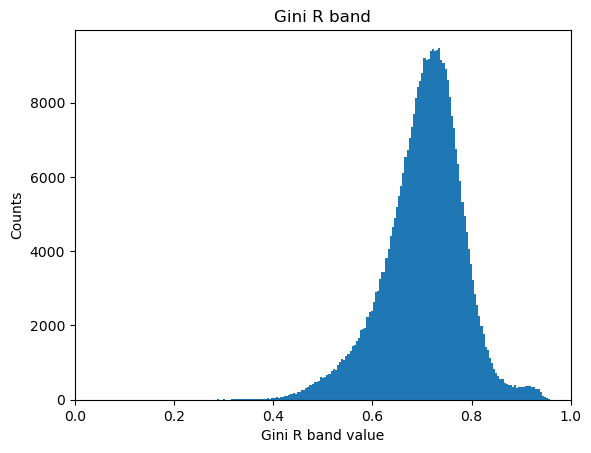

In [35]:
plt.hist(gini_r_band, bins=200)
plt.xlim(0.0, 1.0)
plt.title('Gini R band')
plt.ylabel('Counts')
plt.xlabel('Gini R band value')
plt.show()

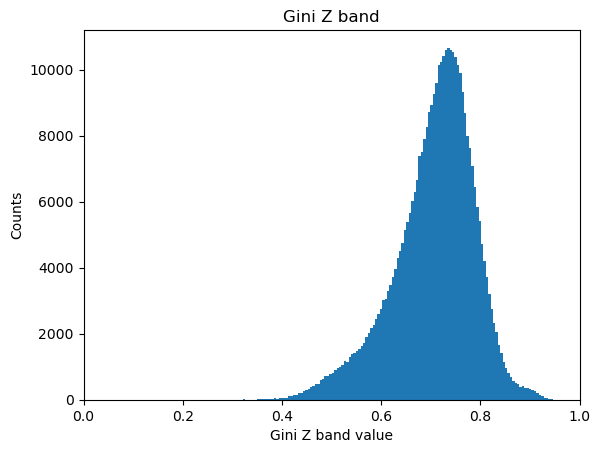

In [36]:
plt.hist(gini_z_band, bins=200)
plt.xlim(0.0, 1.0)
plt.title('Gini Z band')
plt.ylabel('Counts')
plt.xlabel('Gini Z band value')
plt.show()

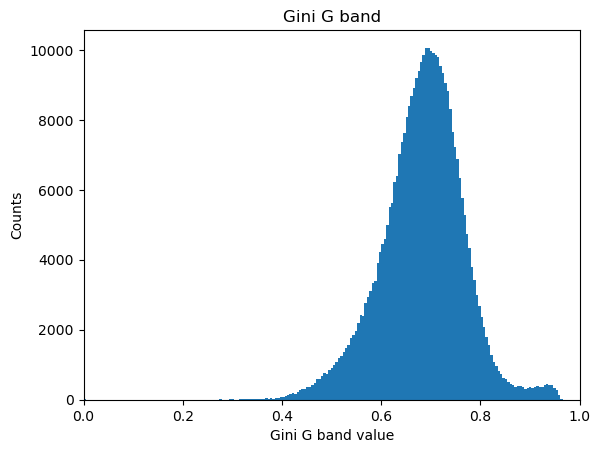

In [37]:
plt.hist(gini_g_band, bins=200)
plt.xlim(0.0, 1.0)
plt.title('Gini G band')
plt.ylabel('Counts')
plt.xlabel('Gini G band value')
plt.show()